In [1]:
!python -V

Python 3.12.2


In [6]:
import pandas as pd

In [7]:
import pickle

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
DATA_EXPERIMENT_YEAR = '2023'

In [14]:
def read_dataframe(filename):

    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_train = read_dataframe(f'../data/green_tripdata_{DATA_EXPERIMENT_YEAR}-01.parquet')
df_val = read_dataframe(f'../data/green_tripdata_{DATA_EXPERIMENT_YEAR}-02.parquet')

In [16]:
len(df_train), len(df_val)

(65946, 62574)

In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.033924005155312

In [23]:
with open(f'../models/lin_reg_{DATA_EXPERIMENT_YEAR}.pkl', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

8.231436941224935

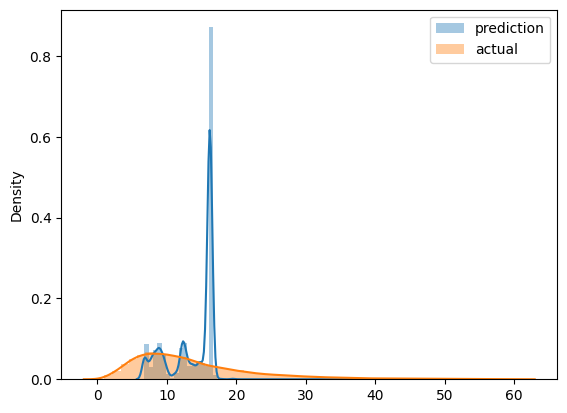

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()